## Topic Modeling w/ LDA & BERTopic

- Load data
- Prepare text for topics
- Create text representations (TF-IDF / embeddings)

-> for modeling:
- classic LDA (sklearn)
- BERTopic 
- Redução dimensional (UMAP)
- Visualization & interpretation
________________________________

------------------
This notebook requires a **dedicated environment**, since BERTopic dependencies
(UMAP, hdbscan, numba) with the main environment of the project.
-------------------

In [1]:
# ===============================================================
# NOTEBOOK 04 — TOPIC MODELING (LDA + BERTopic)
# --->>>>>>> Ambiente dedicado: "topic"  <<<<<<<<<---------
# ===============================================================

# ===============================================================
# NOTEBOOK 04 — TOPIC MODELING (LDA + BERTopic)
# Detecção automática + tentativa de ativação do ambiente
# ===============================================================

import os
import sys
import subprocess

EXPECTED_ENV = "topic"

print("🔧 Checking environment...\n")

current_env = os.environ.get("CONDA_DEFAULT_ENV", None)
print(f"Current env detected: {current_env}")

# -------------------------------------------------------------------
# 1) Se já estamos no ambiente correto → OK
# -------------------------------------------------------------------
if current_env == EXPECTED_ENV:
    print("✅ Environment OK — running inside 'topic'\n")

else:
    print("⚠️ Not running inside the 'topic' environment.")

    print("➡️ Attempting automatic activation...")
    try:
        # Tentativa de ativar o ambiente (funciona fora do Jupyter)
        subprocess.run(["conda", "activate", EXPECTED_ENV], check=True)
        print("✅ Environment activated! Please restart the kernel.")
    except Exception as e:
        print("\n⛔ Automatic activation failed (expected inside Jupyter).")
        print("   To run this notebook correctly, STOP and run:")
        print("""
        conda activate topic
        jupyter notebook
        """)
    # Para a execução do notebook
    raise SystemExit("Stopping execution: wrong environment.")


🔧 Checking environment...

Current env detected: topic
✅ Environment OK — running inside 'topic'



In [3]:
import pandas as pd
import numpy as np
import umap
import hdbscan
from bertopic import BERTopic

print("OK — environment healthy!")

from pathlib import Path

# Caminho dos dados treinados previamente (Amazon Reviews full dataset)
DATA_DIR = Path("../data/processed")

train_path = DATA_DIR / "train_preprocessed.csv"

print("Carregando dados...")
df = pd.read_csv(train_path)

print(df.shape)
df.head()

/home/mcvicentin/anaconda3/envs/topic/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/mcvicentin/anaconda3/envs/topic/lib/python3.10/site-packages/umap/__init__.py:36: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


OK — environment healthy!
Carregando dados...
(50000, 5)


,Unnamed: 0,label,text,clean_text,clean_text_no_stop
0,0,2,Stuning even for the non-gamer: This sound tra...,stuning even for the non gamer this sound trac...,stuning non gamer sound track beautiful paints...
1,1,2,The best soundtrack ever to anything.: I'm rea...,the best soundtrack ever to anything i am read...,best soundtrack reading lot reviews saying bes...
2,2,2,Amazing!: This soundtrack is my favorite music...,amazing this soundtrack is my favorite music o...,amazing soundtrack favorite music time hands i...
3,3,2,Excellent Soundtrack: I truly like this soundt...,excellent soundtrack i truly like this soundtr...,excellent soundtrack truly like soundtrack enj...
4,4,2,"Remember, Pull Your Jaw Off The Floor After He...",remember pull your jaw off the floor after hea...,remember pull jaw floor hearing played game kn...


In [4]:
# Selecionar subset para topic modeling
N = len(df)#10000   

df_topics = df.sample(N, random_state=42).reset_index(drop=True)
df_topics.head()

,Unnamed: 0,label,text,clean_text,clean_text_no_stop
0,33553,2,Every woman should buy this book!: Ever since ...,every woman should buy this book ever since my...,woman buy book mother diagnosed breast cancer ...
1,9427,1,Worst dubbing ever!: Fast beat motivating musi...,worst dubbing ever fast beat motivating music ...,worst dubbing fast beat motivating music avera...
2,199,1,Don't bother: The pillow is tiny and poor qual...,do not bother the pillow is tiny and poor qual...,bother pillow tiny poor quality foam pillow re...
3,12447,1,I'm not sure what I was expecting...but not TH...,i am not sure what i was expecting but not thi...,sure expecting unrelated stock footage annoyin...
4,39489,1,Alright- Not that good: Understood classic by ...,alright not that good understood classic by ot...,alright good understood classic bored read sch...


In [5]:
# TF-IDF (for LDA and exploratory anlysis)
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_df=0.95,
    min_df=10,
    max_features=5000,
    stop_words="english"
)

tfidf_matrix = tfidf.fit_transform(df_topics["clean_text"])

tfidf_matrix.shape

(50000, 5000)

In [6]:
# LDA
from sklearn.decomposition import LatentDirichletAllocation

NUM_TOPICS = 10

lda = LatentDirichletAllocation(
    n_components=NUM_TOPICS,
    random_state=42,
    learning_method="batch"
)

lda_topics = lda.fit_transform(tfidf_matrix)

print("Shape:", lda_topics.shape)

Shape: (50000, 10)


In [7]:
# show top words by topic
def display_topics(model, feature_names, n_top_words=12):
    for idx, topic in enumerate(model.components_):
        print(f"\nTopic {idx}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

feature_names = tfidf.get_feature_names_out()
display_topics(lda, feature_names)


Topic 0:
album, cd, music, songs, song, great, like, best, good, listen, band, love

Topic 1:
product, amazon, great, received, item, service, ordered, work, order, did, works, buy

Topic 2:
coffee, movie, halloween, hot, rice, great, cup, season, good, warm, love, warmer

Topic 3:
book, read, story, books, reading, like, good, characters, great, time, just, novel

Topic 4:
product, use, great, diapers, baby, good, size, just, like, bought, does, used

Topic 5:
movie, film, good, movies, like, story, just, bad, watch, great, acting, time

Topic 6:
dvd, movie, version, video, quality, great, ray, blu, movies, old, disc, vhs

Topic 7:
game, cd, clay, batman, games, songs, voice, music, like, play, song, buy

Topic 8:
book, read, information, good, great, edition, books, kindle, text, author, reading, written

Topic 9:
battery, product, phone, price, good, great, use, camera, buy, does, money, bought


In [8]:
# Bertropic
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

# Cria o modelo
topic_model = BERTopic(
    embedding_model="all-MiniLM-L6-v2",   # modelo leve + rápido
    nr_topics="auto",
    verbose=True
)

topics, probs = topic_model.fit_transform(df_topics["text"])

topic_model.get_topic_info().head()

2025-11-20 16:31:18,027 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████████████████████████████████████████████| 1563/1563 [13:08<00:00,  1.98it/s]
2025-11-20 16:44:34,032 - BERTopic - Embedding - Completed ✓
2025-11-20 16:44:34,034 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-11-20 16:45:24,488 - BERTopic - Dimensionality - Completed ✓
2025-11-20 16:45:24,493 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-11-20 16:45:27,637 - BERTopic - Cluster - Completed ✓
2025-11-20 16:45:27,637 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-11-20 16:45:32,701 - BERTopic - Representation - Completed ✓
2025-11-20 16:45:32,703 - BERTopic - Topic reduction - Reducing number of topics
2025-11-20 16:45:37,953 - BERTopic - Topic reduction - Reduced number of topics from 598 to 77


,Topic,Count,Name,Representation,Representative_Docs
0,-1,19041,-1_the_and_this_it,"[the, and, this, it, to, of, is, in, that, was]","[A Good Book: This is a good book, but it does..."
1,0,27449,0_the_and_of_to,"[the, and, of, to, is, it, this, in, that, book]",[What a sad sad trip it's been: I have read th...
2,1,267,1_battery_charger_charge_batteries,"[battery, charger, charge, batteries, camera, ...",[12v battery charger: This product was less th...
3,2,206,2_printer_hp_paper_print,"[printer, hp, paper, print, feed, printers, ca...",[Out of Paper: I have had this printer for abo...
4,3,188,3_tivo_wireless_adapter_network,"[tivo, wireless, adapter, network, dvr, works,...",[TIVO wireless G Adapter: Attach to your TIVO ...


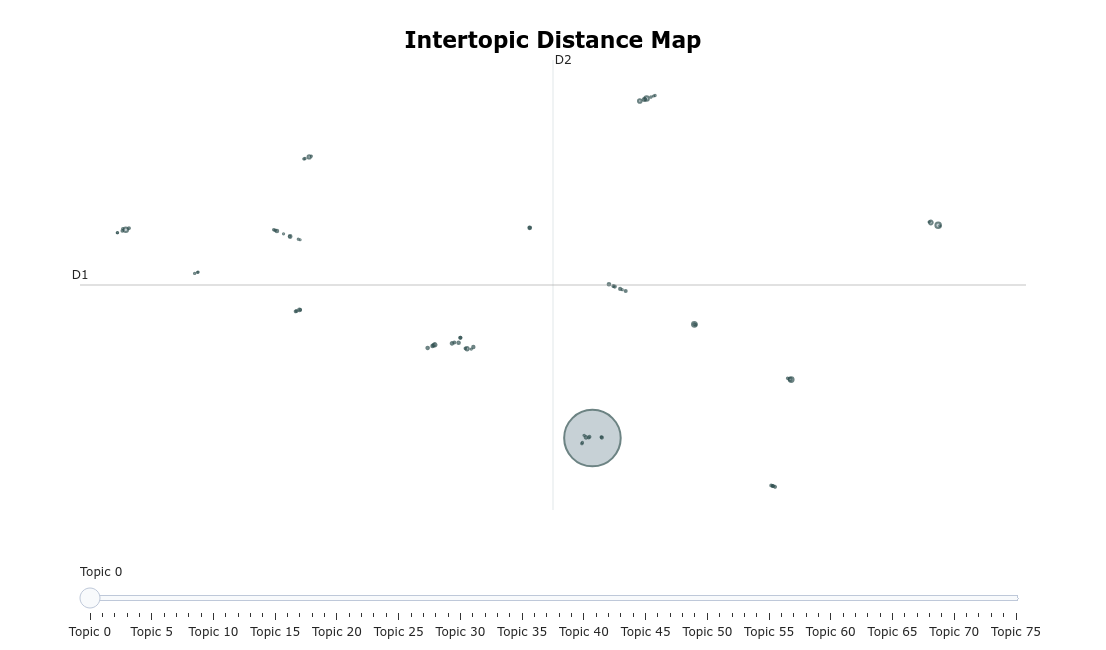

In [9]:
# visualize topics
topic_fig = topic_model.visualize_topics()
topic_fig.show()

In [10]:
# table of topics
topic_model.get_topic_info().head(15)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,19041,-1_the_and_this_it,"[the, and, this, it, to, of, is, in, that, was]","[A Good Book: This is a good book, but it does..."
1,0,27449,0_the_and_of_to,"[the, and, of, to, is, it, this, in, that, book]",[What a sad sad trip it's been: I have read th...
2,1,267,1_battery_charger_charge_batteries,"[battery, charger, charge, batteries, camera, ...",[12v battery charger: This product was less th...
3,2,206,2_printer_hp_paper_print,"[printer, hp, paper, print, feed, printers, ca...",[Out of Paper: I have had this printer for abo...
4,3,188,3_tivo_wireless_adapter_network,"[tivo, wireless, adapter, network, dvr, works,...",[TIVO wireless G Adapter: Attach to your TIVO ...
5,4,173,4_blades_razor_gillette_shave,"[blades, razor, gillette, shave, fusion, blade...",[These blades are not the real thing.: These b...
6,5,167,5_vacuum_hoover_suction_cord,"[vacuum, hoover, suction, cord, dirt, it, rewi...",[Great Vacuum: Great Vacuum. Works very well b...
7,6,124,6_apple_adapter_g4_power,"[apple, adapter, g4, power, charger, powerbook...",[Be careful - product has changed?: I bought o...
8,7,113,7_sharpener_pencil_pencils_sharpen,"[sharpener, pencil, pencils, sharpen, acto, sh...",[Does not Sharpen Evenly!: I thought this shar...
9,8,100,8_case_palm_bag_clip,"[case, palm, bag, clip, tx, belt, pouch, backp...","[Great protective armor case, better than the ..."


In [11]:
# inspect one topic
topic_model.get_topic(10)

[('light', 0.056763995782349454),
 ('lamp', 0.04335473326021958),
 ('flashlight', 0.03063549356453835),
 ('bulb', 0.023073812363392843),
 ('batteries', 0.021919132578976906),
 ('bulbs', 0.018371204473535355),
 ('lava', 0.017661370461801107),
 ('lights', 0.01563969938270376),
 ('ott', 0.015405512405951456),
 ('flashlights', 0.014121719705455501)]

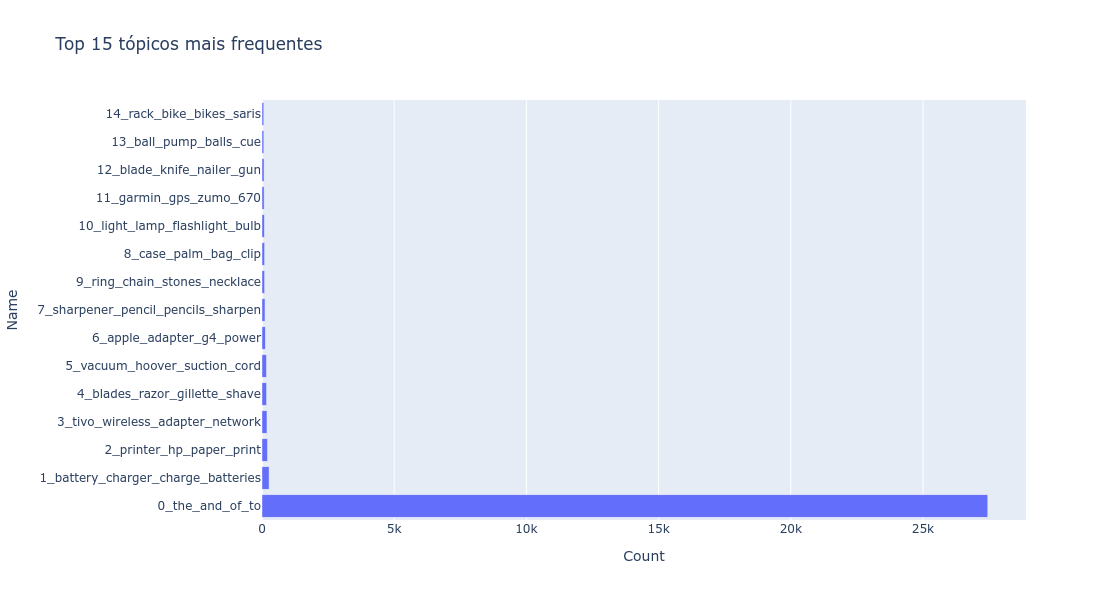

In [15]:
# bar plot
import plotly.express as px

df_plot = topic_info[topic_info.Topic >= 0].sort_values("Count", ascending=False).head(15)

fig = px.bar(
    df_plot,
    x="Count",
    y="Name",
    orientation="h",
    title="Top 15 tópicos mais frequentes",
    height=600
)

fig.show()

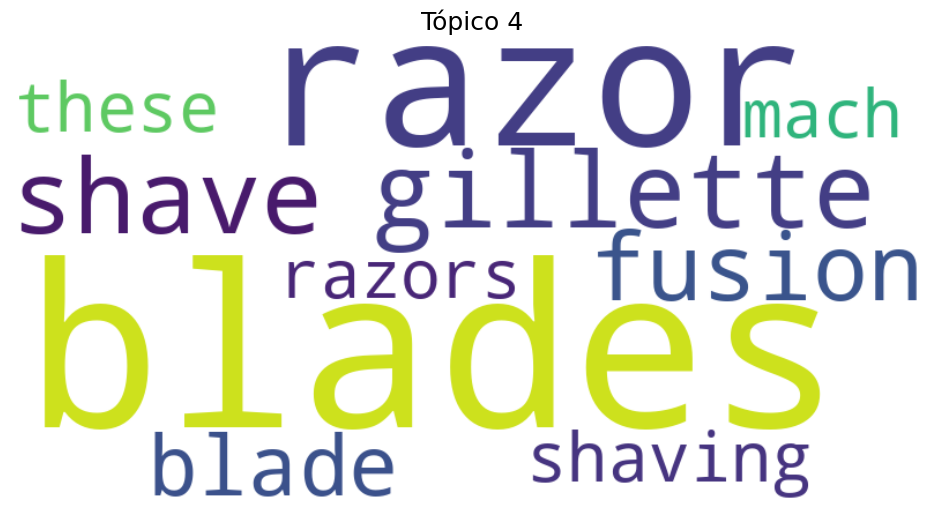

In [20]:
# wordcloud/topic
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordcloud(topic_id):
    words = dict(topic_model.get_topic(topic_id))
    wc = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(words)
    
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Tópico {topic_id}", fontsize=18)
    plt.show()

plot_wordcloud(4)

In [23]:
docs = df_topics["text"].tolist()

doc_info = topic_model.get_document_info(docs)
doc_info.head()

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,Every woman should buy this book!: Ever since ...,-1,-1_the_and_this_it,"[the, and, this, it, to, of, is, in, that, was]","[A Good Book: This is a good book, but it does...",the - and - this - it - to - of - is - in - th...,0.000000,False
1,Worst dubbing ever!: Fast beat motivating musi...,0,0_the_and_of_to,"[the, and, of, to, is, it, this, in, that, book]",[What a sad sad trip it's been: I have read th...,the - and - of - to - is - it - this - in - th...,0.501432,False
2,Don't bother: The pillow is tiny and poor qual...,0,0_the_and_of_to,"[the, and, of, to, is, it, this, in, that, book]",[What a sad sad trip it's been: I have read th...,the - and - of - to - is - it - this - in - th...,0.041612,False
3,I'm not sure what I was expecting...but not TH...,-1,-1_the_and_this_it,"[the, and, this, it, to, of, is, in, that, was]","[A Good Book: This is a good book, but it does...",the - and - this - it - to - of - is - in - th...,0.000000,False
4,Alright- Not that good: Understood classic by ...,0,0_the_and_of_to,"[the, and, of, to, is, it, this, in, that, book]",[What a sad sad trip it's been: I have read th...,the - and - of - to - is - it - this - in - th...,0.962255,False


In [24]:
# SUMMARy per topic
from transformers import pipeline

summarizer = pipeline("summarization", model="t5-small")

def summarize_topic(topic_id, n_samples=30):
    # Filtra documentos daquele tópico
    subset = doc_info[doc_info["Topic"] == topic_id]
    
    if subset.empty:
        return f"[Tópico {topic_id}] sem documentos suficientes para sumarizar."
    
    # Garante que não tentamos amostrar mais do que existe
    n = min(n_samples, len(subset))
    texts = subset["Document"].sample(n, random_state=42).tolist()
    
    # Junta textos em um bloco só (limitado para não explodir o modelo)
    joined = " ".join(texts)[:4000]  # T5 tem limite de tokens
    
    summary = summarizer(
        joined,
        max_length=120,
        min_length=40,
        do_sample=False
    )
    return summary[0]["summary_text"]

for t in [0, 1, 2, 3, 4]:
    print(f"\n===== TÓPICO {t} =====")
    print(summarize_topic(t))

Device set to use cpu
Token indices sequence length is longer than the specified maximum sequence length for this model (1001 > 512). Running this sequence through the model will result in indexing errors



===== TÓPICO 0 =====


Both `max_new_tokens` (=256) and `max_length`(=120) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


cds is the most original, most enjoyable, and most unique metal album i have ever heard . the book has everything or as Ronald Raegan would say it is the perfect yarn . it has a lot of good insight on ways to motivate yourself .

===== TÓPICO 1 =====


Both `max_new_tokens` (=256) and `max_length`(=120) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Xantrex has seriously bad quality control, if not nonexistent . it plugs into the wall, it charges the battery . if it gets bumped slightly, or has too much pressure on the cord just laying there, it comes out .

===== TÓPICO 2 =====


Both `max_new_tokens` (=256) and `max_length`(=120) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


a new printer is being shipped to the u.s. this year . it's the worst peripheral device I have come across . the printer is a great product at an outstanding price . you can make labels for your needs and wants .

===== TÓPICO 3 =====


Both `max_new_tokens` (=256) and `max_length`(=120) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


tivo wireless adapter is perfect for my Series 2 DT Tivo box . it works as promised and works perfectly as advertised . I ordered the TIVO 2 years after 8.1 was released . this adapter was easly to install .

===== TÓPICO 4 =====


Both `max_new_tokens` (=256) and `max_length`(=120) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


the Fusion blades are my favorite razor . they cause the least amount of pain, and get the closest shave out of anything I've used . this is the worst system gillette has ever released .
